In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import math
import numpy as np
import pathlib
%matplotlib inline

linkSequentialData = 'data/sequential_data'
path = pathlib.Path().absolute().parent / linkSequentialData / 'metrics'
pathesMetrics = list(path.glob('*.csv'))

nodes = {}
nodes['link'] = pathesMetrics
nodes['name'] = list(map(lambda x: x.name[:x.name.find('_')], nodes['link']))
nodes['data'] = list(map(lambda x: pd.read_csv(x), nodes['link']))

In [2]:
timeStart = datetime.strptime('2019-11-19 18:38:39', '%Y-%m-%d %H:%M:%S')
timeEnd = datetime.strptime('2019-11-20 02:30:00', '%Y-%m-%d %H:%M:%S')

nodes['dataExperiment'] = []

for i in range(len(nodes['data'])):
    # convert string to timestamp
    nodes['data'][i]['now'] = nodes['data'][i]['now'].map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S CEST'))
    # filter out the timestamps that are outside of the experiment
    nodes['dataExperiment'].append(nodes['data'][i][(nodes['data'][i]['now'] >= timeStart) & (nodes['data'][i]['now'] <= timeEnd)])   

In [3]:
for i in range(len(nodes['dataExperiment'])):
    print('Size of metrics', nodes['name'][i], '=', nodes['dataExperiment'][i]['now'].size)

Size of metrics wally122 = 46568
Size of metrics wally113 = 26228
Size of metrics wally124 = 47518
Size of metrics wally123 = 42831
Size of metrics wally117 = 51614


In [4]:
# calculation the mean values for each timestamp 
for i in range(len(nodes['dataExperiment'])):
    nodes['dataExperiment'][i] = nodes['dataExperiment'][i].groupby('now').mean().reset_index()

In [5]:
for i in range(len(nodes['dataExperiment'])):
    print('Size of metrics', nodes['name'][i], 'after averaging =', nodes['dataExperiment'][i]['now'].size)

Size of metrics wally122 after averaging = 28279
Size of metrics wally113 after averaging = 23206
Size of metrics wally124 after averaging = 28280
Size of metrics wally123 after averaging = 28280
Size of metrics wally117 after averaging = 28280


In [6]:
# create array of all gaps in metrics
nodes['gaps'] = []
for data in nodes['dataExperiment']:
    data['gap'] = (data['now'].diff()).dt.seconds > 1
    gaps = []
    timestampsAfterGaps = list(data[data['gap']]['now'])
    for e in timestampsAfterGaps:
        s = list(data[data['now'] < e].tail(1)['now'])
        g = pd.date_range(s[0], e, freq = 'S')
        g.freq = None
        g = list(g)
        gaps += g[1:-1]
    nodes['gaps'].append(gaps)        

In [7]:
for i in range(len(nodes['gaps'])):
    print('Number of gaps in', nodes['name'][i],'=', len(nodes['gaps'][i]))

Number of gaps in wally122 = 3
Number of gaps in wally113 = 5076
Number of gaps in wally124 = 2
Number of gaps in wally123 = 2
Number of gaps in wally117 = 2


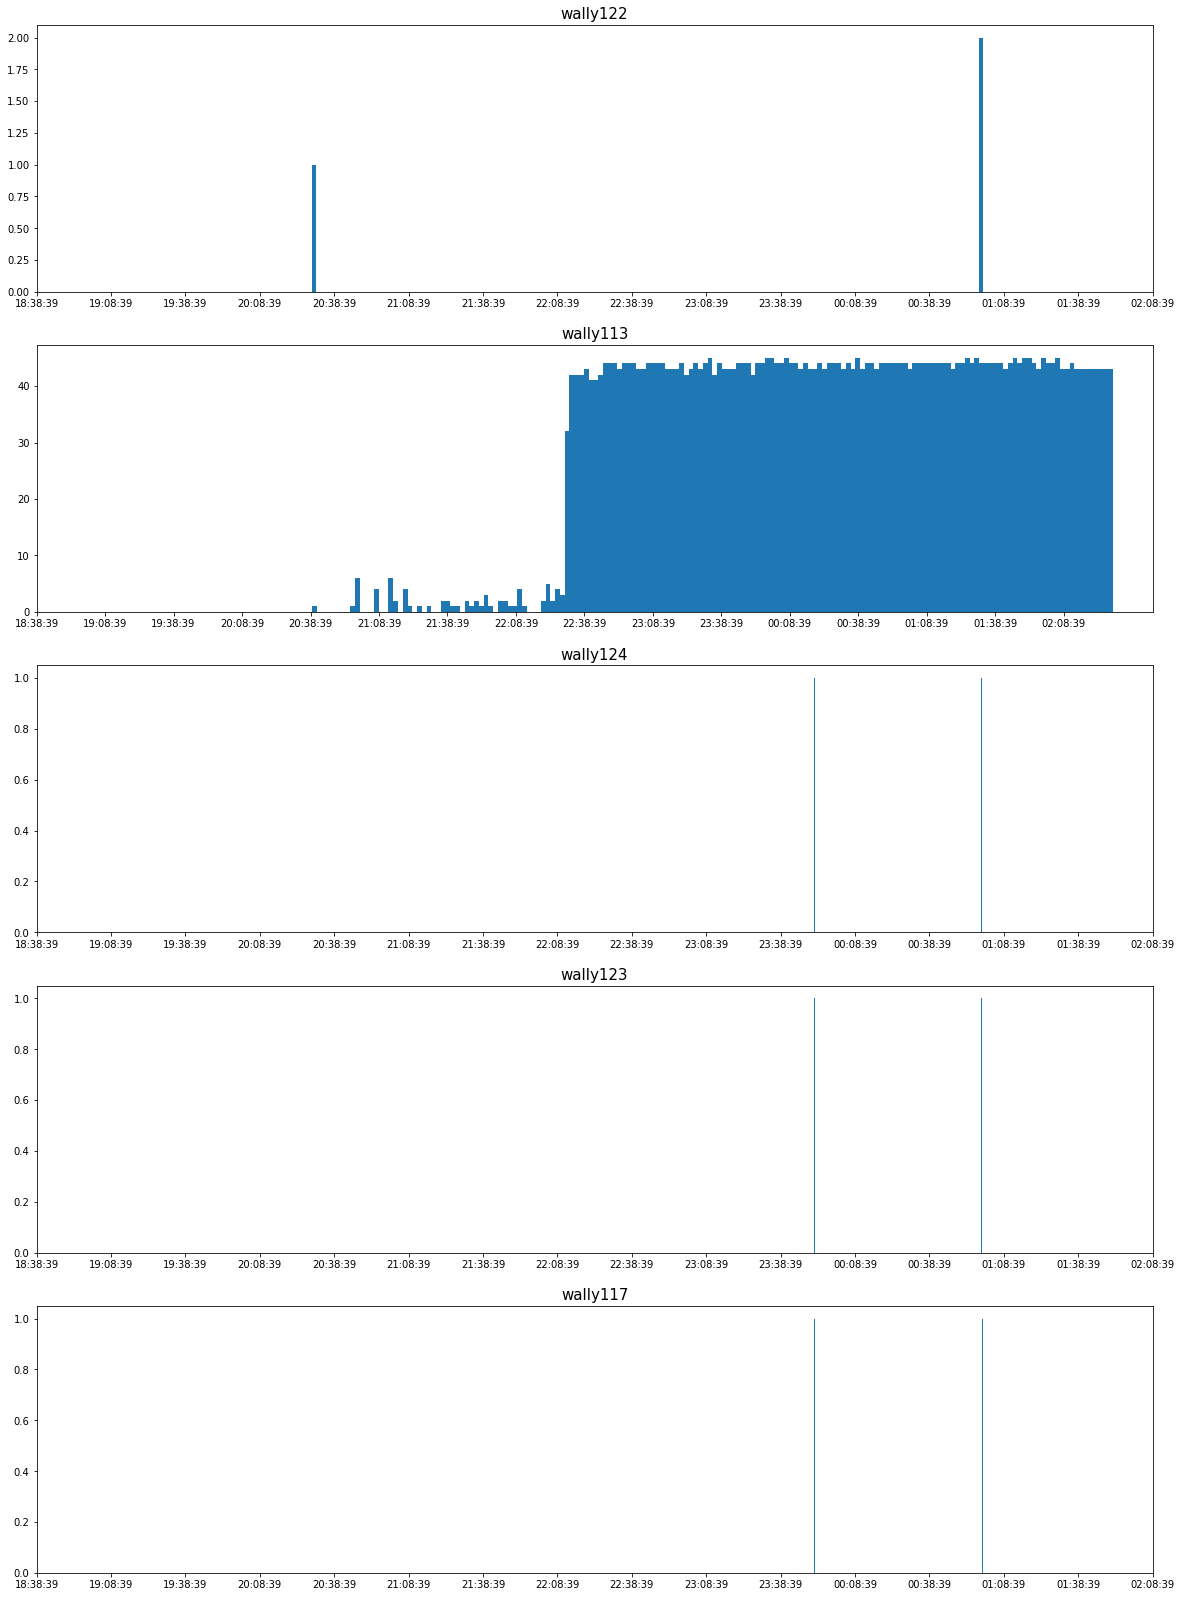

In [8]:
# plotting the distribution of gaps
allTimestamps = list(pd.date_range(timeStart, timeEnd, freq = 'S'))

fig, axes = plt.subplots(len(nodes['gaps']), 1, figsize=(20, 20))

#size = round((28282) ** (1. / 3) * 2) #Rice’s Rule
#size = round(28282 / 60)
size = round(math.sqrt(len(allTimestamps)))

for i in range(len(nodes['gaps'])):
    axes[i].hist(nodes['gaps'][i], bins = size)
    axes[i].set_title(nodes['name'][i], fontsize = 15)
    
plt.subplots_adjust(top = 1.2)
myFmt = mdates.DateFormatter('%H:%M:%S')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(list(pd.date_range(timeStart, timeEnd, freq = '1800S')))
    plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

In [9]:
# calculation the max duration for all nodes
nodes['twoGapsForPlot'] = []
i = 0
while i < len(nodes['gaps']):
    m1, m2 = 1, 1
    m1Time, m2Time = nodes['gaps'][i][0], nodes['gaps'][i][0]
    j = 0
    while j <= (len(nodes['gaps'][i]) - 1):
        k = 1
        while (j + k < len(nodes['gaps'][i])) and ((nodes['gaps'][i][j] + timedelta(seconds = k)) == nodes['gaps'][i][j + k]):
            k += 1
        if k >= m1:
            if m1 > m2:
                m2 = m1
                m2Time = m1Time
            else: 
                m1 = k
                m1Time = nodes['gaps'][i][j]
        j += k
    nodes['twoGapsForPlot'].append([(m2, m2Time), (m1, m1Time)])
    i += 1           

In [10]:
for i in range(len(nodes['gaps'])):
    print('The max duration of gaps in', nodes['name'][i],'=', nodes['twoGapsForPlot'][i][-1][0], 'second(-s)')

The max duration of gaps in wally122 = 1 second(-s)
The max duration of gaps in wally113 = 2 second(-s)
The max duration of gaps in wally124 = 1 second(-s)
The max duration of gaps in wally123 = 1 second(-s)
The max duration of gaps in wally117 = 1 second(-s)


In [11]:
# autoscaling of y-axis based on the data
def autoscaleY(ax, xlim, margin = 0.1):

    def getYlim(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo, hi  = xlim[0], xlim[-1]
        newYd = yd[((xd >= lo) & (xd <= hi))]
        h = np.max(newYd) - np.min(newYd)
        bot = np.min(newYd) - margin * h
        top = np.max(newYd) + margin * h
        return bot,top

    lines = ax.get_lines()
    bot, top = np.inf, -np.inf

    for line in lines:
        newBot, newTop = getYlim(line)
        if newBot < bot: bot = newBot
        if newTop > top: top = newTop

    ax.set_ylim(bot * 0.95, top * 1.05)


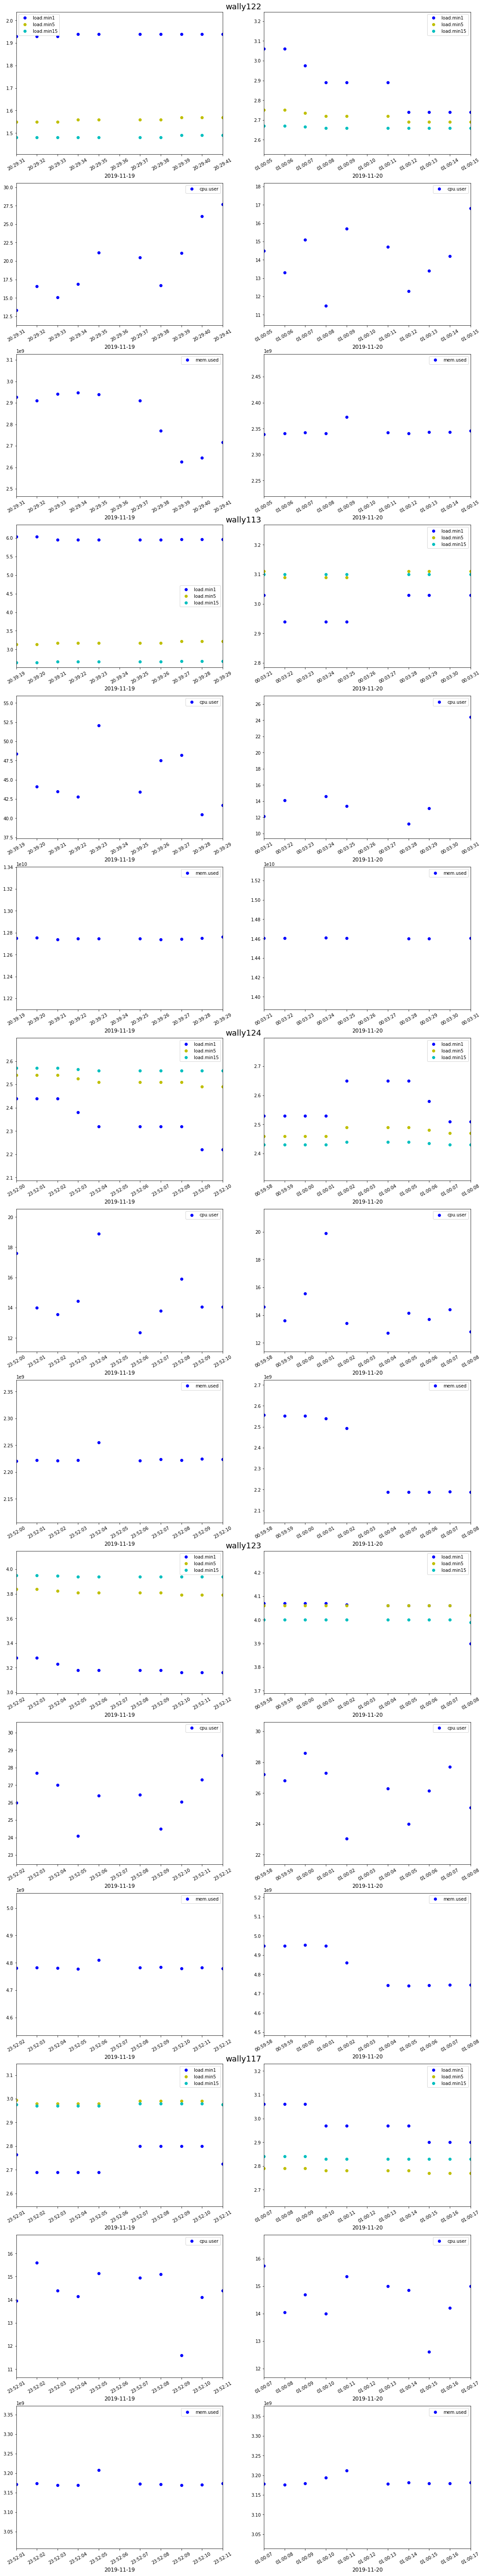

In [12]:
# plotting the load.min1, load.min2 and load.min15 for two gaps
def plotLoads(axrow, data, xlims):
    for i in range(numberOfGaps):
        axrow[i].plot('now', 'load.min1', 'bo', label = 'load.min1', data = data)
        axrow[i].plot('now', 'load.min5', 'yo', label = 'load.min5', data = data)
        axrow[i].plot('now', 'load.min15', 'co', label = 'load.min15', data = data)
        axrow[i].legend()
        axrow[i].set_xlim(xlims[i])
        g = xlims[i][0] + timedelta(seconds = 5)
        axrow[i].set_xlabel(g.date(), fontsize = 12)
        autoscaleY(axrow[i], xlims[i])
    
# plotting the cpu.user or mem.used for two gaps
def plotCpuOrMem(feature, axrow, data, xlims):
    for i in range(numberOfGaps):
        axrow[i].plot('now', feature, 'bo', label = feature, data = data)
        axrow[i].legend()
        axrow[i].set_xlim(xlims[i])
        g = xlims[i][0] + timedelta(seconds = 5)
        axrow[i].set_xlabel(g.date(), fontsize = 12)
        autoscaleY(axrow[i], xlims[i])
    
numberOfGaps = 2
fig, axes = plt.subplots(len(nodes['dataExperiment']) * 3, numberOfGaps)

j = 0
for i in range(0, len(axes), 3):
    twoXlims = [[nodes['twoGapsForPlot'][j][0][1] - timedelta(seconds = 5), 
                nodes['twoGapsForPlot'][j][0][1] + timedelta(seconds = 5)], 
                [nodes['twoGapsForPlot'][j][1][1] - timedelta(seconds = 5), 
                nodes['twoGapsForPlot'][j][1][1] + timedelta(seconds = 5)]]
    axes[i, 0].set_title(nodes['name'][j], fontsize = 18, x = 1.1)
    plotLoads(axes[i], nodes['dataExperiment'][j], twoXlims)
    plotCpuOrMem('cpu.user', axes[i + 1], nodes['dataExperiment'][j], twoXlims)
    plotCpuOrMem('mem.used', axes[i + 2], nodes['dataExperiment'][j], twoXlims)
    j += 1

plt.subplots_adjust(top = 20, right = 2.5)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 30)

plt.show()
